In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import time

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress

#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

# for dic in recipes:
#     ingredients = []
#     for ingredient in dic['ingredients']:
#         tmp_ingredient = ingredient.replace(' ', '-')
#         ingredients.append(tmp_ingredient)
#         dic['ingredients'] = ingredients

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

# vectorizer = TfidfVectorizer(use_idf=True, token_pattern=r"(?u)\b\w[\w-]*\w\b")
vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    # one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

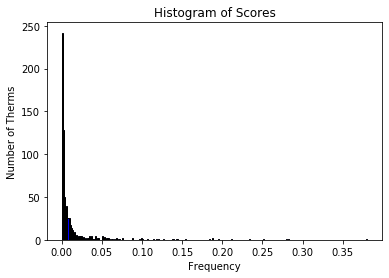

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [7]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:15,:])


#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/synthetic250000.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}
CUISINE_TOP_SCORE_THRESHOLD = 0.1
for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>CUISINE_TOP_SCORE_THRESHOLD]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score, row['term']])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs.

But first, in order to optimize computation we first calculate ngrams of unique items.

In [11]:
items_ngrams = {}
for basket in baskets:
    for item in basket:
        if items_ngrams.get(item) is None :
            items_ngrams[item] = list(ngrams(item, 3))

In [12]:
start_time = time.time()
baskets_scores = []
all_similarities = {}
for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        sims = 0
        for item in basket:      
            item_ngram = items_ngrams[item]
            for ngram_term, score, term in top_scores_ngram[cuisine]:
                if all_similarities.get(item+term) is None:
                    if all_similarities.get(term+item) is None:
                        sim = jaccard_distance(item_ngram, ngram_term)
                        all_similarities[item+term] = sim
                        all_similarities[term+item] = sim
                    else:
                        sim = all_similarities[term+item]
                else:
                    sim = all_similarities[item+term]

                if sim > 0.2:
                    value += sim * score
                    sims += sim
        if sims != 0:
            value = value/sims
        else:
            value=0
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()
print("--- %s seconds ---" % (time.time() - start_time))

--- 315.4726276397705 seconds ---


In [13]:
# save this data if you want to run elki clustering from dbscanELKI.sh script
baskets_scores_df.to_csv('./data/basket_scores250000.csv', header=False, index=False)

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [34]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [113]:
# OPTICS
optics = OPTICS(min_samples=100, eps=1e-15, cluster_method='dbscan')
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

labels_db_scan = cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=1e-15)

print(set(labels_db_scan))

{0, 1, 2, 3, 4, 5, 6, 7, -1}
{0, 1, 2, 3, 4, 5, 6, 7, -1}


In [36]:
# K-Means
# kMeans = KMeans(n_clusters=7, random_state=0).fit(X)
# kMeans_labels = kMeans.labels_
# print(set(kMeans_labels))

In [143]:
# DBSCAN 
[eps, min_samples] = [1e-15, 100]
dbScan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1, algorithm='kd_tree').fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])

{0, 1, 2, 3, 4, 5, 6, 7, -1}
[1e-15, 100]


In [147]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=100)
clusterer = clusterer.fit(X)
print(set(clusterer.labels_))
print(len(set(clusterer.labels_)))


{0, 1, 2, 3, 4, 5, 6, 7, -1}
9


#### Analysis of the method
Observe size of created basket clusters

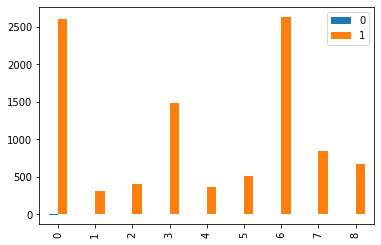

In [148]:
labels = clusterer.labels_
cluster_sizes = []
for label in sorted(set(labels)):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')


Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [149]:
for selected_basket_cluster in set(clusterer.labels_):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    print("#Baskets: ", selected_basket_scores.shape[0])
    aggregated_basket_cluster_score \
        = np.mean(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
#Baskets:  317
italian         2.250320
mexican         1.677761
greek           1.497782
brazilian       1.380905
british         1.027210
thai            0.901154
irish           0.868199
french          0.783554
russian         0.634044
southern_us     0.615084
jamaican        0.553289
filipino        0.426033
cajun_creole    0.099478
spanish        -0.317211
indian         -0.326024
moroccan       -0.390361
korean         -0.505908
chinese        -0.515362
japanese       -0.524047
vietnamese     -0.576202
dtype: float64
Cluster  1
#Baskets:  406
italian         2.250320
mexican         1.685422
greek           1.661469
french          0.604374
southern_us     0.392434
russian        -0.178616
cajun_creole   -0.252500
irish          -0.272077
british        -0.295985
spanish        -0.322303
moroccan       -0.390361
indian         -0.487864
korean         -0.505908
japanese       -0.529336
chinese        -0.533762
vietnamese     -0.576202
thai           -0.680426
filipino

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [40]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X_Baskets = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X_Baskets)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 vegetables
 other
 root
 milk
 whole
 fruit
 frozen
 yogurt
 cheese
 bread
Cluster 1:
 bags
 shopping
 yogurt
 coffee
 bread
 soda
 beverages
 sausage
 products
 cheese
Cluster 2:
 buns
 rolls
 milk
 soda
 sausage
 whole
 bottled
 cheese
 vegetables
 yogurt
Cluster 3:
 cream
 whipped
 sour
 vegetables
 milk
 fruit
 whole
 other
 ice
 cheese
Cluster 4:
 pastry
 newspapers
 soda
 fruit
 yogurt
 sausage
 citrus
 milk
 margarine
 coffee
Cluster 5:
 fruit
 juice
 vegetable
 tropical
 pip
 citrus
 milk
 vegetables
 yogurt
 cheese
Cluster 6:
 bottled
 soda
 beer
 water
 liquor
 wine
 vegetables
 fruit
 white
 milk
Cluster 7:
 canned
 beer
 soda
 shopping
 bags
 buns
 rolls
 vegetables
 newspapers
 bottled
Cluster 8:
 milk
 whole
 butter
 yogurt
 fruit
 bread
 pastry
 newspapers
 bottled
 soda
Cluster 9:
 specialty
 chocolate
 bar
 soda
 buns
 rolls
 milk
 marshmallow
 candy
 vegetables


#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [41]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.mean(basket_scores,axis=0).sort_values()
    np.argsort(cluster_scores)
    print(cluster_scores)

japanese        0.092458
french          0.149318
korean          0.150749
chinese         0.153758
vietnamese      0.153863
indian          0.154722
italian         0.161727
russian         0.162000
spanish         0.165602
irish           0.175525
greek           0.182353
moroccan        0.191414
southern_us     0.201440
jamaican        0.203807
filipino        0.215637
mexican         0.215757
british         0.220573
cajun_creole    0.226103
brazilian       0.259455
thai            0.294279
dtype: float64
brazilian      -0.264501
british        -0.183103
filipino       -0.170498
thai           -0.164189
jamaican       -0.164092
irish          -0.156982
russian        -0.140618
southern_us    -0.129468
japanese       -0.056133
chinese        -0.043726
korean         -0.031519
vietnamese     -0.020399
french         -0.011942
indian         -0.009683
italian         0.027727
mexican         0.041946
greek           0.052015
cajun_creole    0.063348
moroccan        0.072793
spanish   